In [5]:
import numpy as np # linear algebra
import pandas as pd # reading and processing of tables
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
# from skimage.util.montage import montage2d
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# import dicom
import scipy.misc
CT_OFFSET = 1024
ZERO_VALUE = -2000
import keras

In [3]:
# we want to crop out the regions we dont need first
def _dsum(carr,  # type: np.ndarray
          cax  # type: int
          ):
    # type: (np.ndarray, int) -> np.ndarray
    return np.sum(carr, tuple(n for n in range(carr.ndim) if n is not cax))

def get_bbox(in_vol,
             min_val=0):
    # type: (np.ndarray, float) -> List[Tuple[int,int]]
    ax_slice = []
    for i in range(in_vol.ndim):
        c_dim_sum = _dsum(in_vol > min_val, i)
        wh_idx = np.where(c_dim_sum)[0]
        c_sl = sorted(wh_idx)
        if len(wh_idx) == 0:
            ax_slice += [(0, 0)]
        else:
            ax_slice += [(c_sl[0], c_sl[-1] + 1)]
    return ax_slice

def apply_bbox(in_vol,  # type: np.ndarray
               bbox_list,  # type: List[Tuple[int,int]]
               pad_values = False,
               padding_mode = 'edge'
               ):
    return in_vol.__getitem__([slice(a, b, 1) for (a, b) in bbox_list])

def autocrop(in_vol,  # type: np.ndarray
             min_val  # type: double
             ):
    return apply_bbox(in_vol, get_bbox(in_vol,
                                       min_val=min_val))

In [4]:
def get_segmented_lungs(in_im, plot=False):
    im = in_im.copy() # don't change the input
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(3, 3, figsize=(10, 10))
        plots = plots.flatten()
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < -400
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
        plots[0].set_title('First Threshold')
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
        plots[1].set_title('Remove Border')
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.gist_earth)
        plots[2].set_title('Label Components')
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
        plots[3].set_title('Keep Biggest 2')
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone)
        plots[4].set_title('Erosion')
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
        plots[5].set_title('Close Image')
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
        plots[6].set_title('Fill holes')
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = (binary == 0)
    im[get_high_vals] = ZERO_VALUE # minimum value
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        plots[7].set_title('Binary Masked Input')
        
    return im

In [6]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

In [7]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array
img_path = "datasetsSARS-COV-2 Ct-Scan\\COVID-positive\\Covid (1).png"
img_array = (get_img_array(img_path, size=image_size))

In [8]:
img_array

array([[[[190., 190., 190.],
         [202., 202., 202.],
         [199., 199., 199.],
         ...,
         [197., 197., 197.],
         [200., 200., 200.],
         [193., 193., 193.]],

        [[189., 189., 189.],
         [194., 194., 194.],
         [190., 190., 190.],
         ...,
         [195., 195., 195.],
         [202., 202., 202.],
         [188., 188., 188.]],

        [[195., 195., 195.],
         [199., 199., 199.],
         [187., 187., 187.],
         ...,
         [196., 196., 196.],
         [197., 197., 197.],
         [190., 190., 190.]],

        ...,

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
       

TypeError: Invalid shape (1, 180, 180, 3) for image data

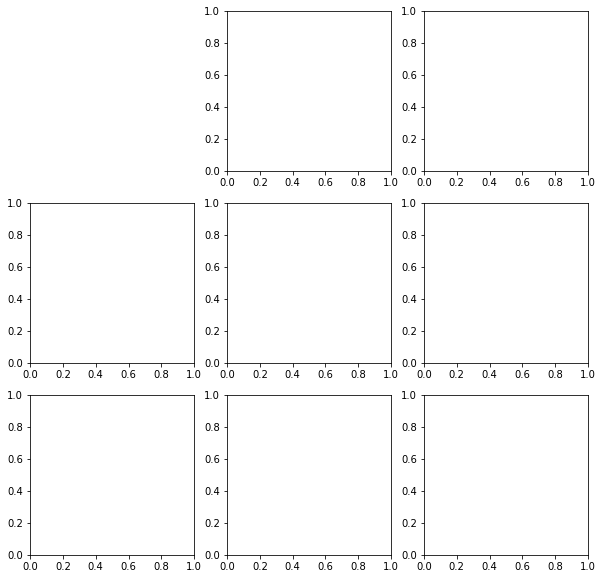

In [9]:
get_segmented_lungs(img_array, True)